In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torchinfo import summary


import timm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
import warnings
import random
from IPython.display import display
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set seed
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# -----------------------------------------------------------------------------
# Global variables
# -----------------------------------------------------------------------------

LEARNING_RATE = 1e-4
BATCH_SIZE = 1024
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

DATA_PATH = '/kaggle/input/2-deep-learning-cs-5364-lab-1-nivel-1'

N_GPU = torch.cuda.device_count() if torch.cuda.is_available() else 0
print(f"Número de GPUs disponibles: {N_GPU}")

CKPT_PATH = "checkpoint.pth.tar"

Número de GPUs disponibles: 2


(170000, 3)
Label
0     5000
1     5000
2     5000
3     5000
4     5000
5     5000
6     5000
7     5000
8     5000
9     5000
10    5923
11    6742
12    5958
13    6131
14    5842
15    5421
16    5918
17    6265
18    5851
19    5949
20    6000
21    6000
22    6000
23    6000
24    6000
25    6000
26    6000
27    6000
28    6000
29    6000
Name: count, dtype: int64
170000
136000 34000


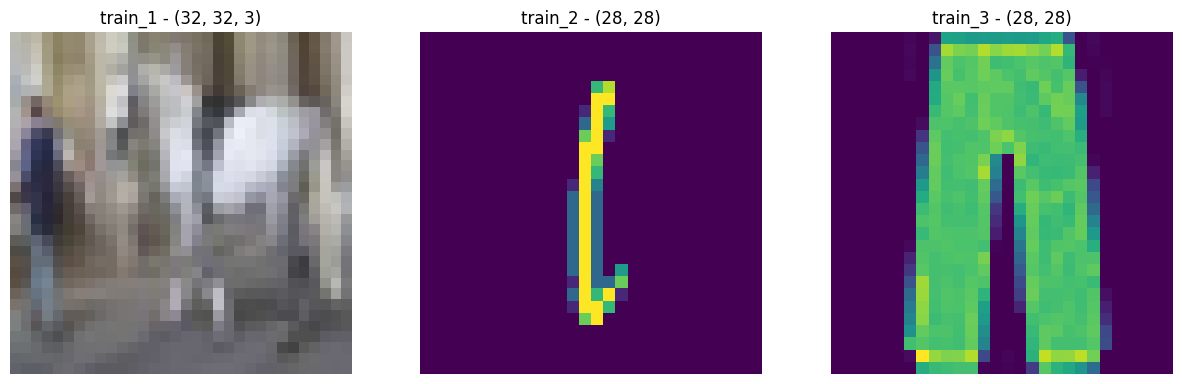

In [2]:

# -----------------------------------------------------------------------------
# Analyze dataset
# -----------------------------------------------------------------------------

train_dataset = pd.concat([
    pd.read_csv(f'{DATA_PATH}/train_1.csv').assign(dataset='train_1'),
    pd.read_csv(f'{DATA_PATH}/train_2.csv').assign(dataset='train_2'),
    pd.read_csv(f'{DATA_PATH}/train_3.csv').assign(dataset='train_3'),
], ignore_index=True)

print(train_dataset.shape)

train_dataset['ImageId'] = train_dataset['ImageId'].apply(lambda x: x + '.png' if not x.endswith('.png') else x)
train_dataset['Path'] = train_dataset.apply(
    lambda x: f'{DATA_PATH}/NIVEL1/NIVEL1/TRAIN/{x["dataset"]}/{x["ImageId"]}', axis=1
)

train_1 = train_dataset[train_dataset['dataset'] == 'train_1']
train_2 = train_dataset[train_dataset['dataset'] == 'train_2']
train_3 = train_dataset[train_dataset['dataset'] == 'train_3']

print(train_dataset['Label'].value_counts().sort_index())
# print(train_dataset['Label'].value_counts(normalize=True).sort_index())

def split_data(data):
    train, val = train_test_split(data, test_size=0.2, random_state=seed, stratify=data['Label'])
    return train, val

# each folder is one of MNIST, CIFAR10, FASHION MNIST
train_1_train, train_1_val = split_data(train_1)
train_2_train, train_2_val = split_data(train_2)
train_3_train, train_3_val = split_data(train_3)

train_df = pd.concat([train_1_train, train_2_train, train_3_train]).reset_index(drop=True)
val_df = pd.concat([train_1_val, train_2_val, train_3_val]).reset_index(drop=True)

print(len(train_dataset))
print(len(train_df), len(val_df))

# -----------------------------------------------------------------------------
# Plot sample of each dataset
# -----------------------------------------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, dataset in enumerate(train_dataset['dataset'].unique()):
    img_row = train_dataset[train_dataset['dataset'] == dataset].sample(1)
    # print(img_row['Path'].values[0])
    # img_path = f"{DATA_PATH}/NIVEL1/NIVEL1/TRAIN/{img_row[2]}/{img_row[0]}"
    img_path = img_row['Path'].values[0]
    img_label = img_row['Label'].values[0]
    # print(img_path)
    image = plt.imread(img_path)
    axs[i].imshow(image)
    axs[i].set_title(dataset + ' - ' + image.shape.__str__())
    axs[i].axis('off')
plt.show()



In [3]:

# -----------------------------------------------------------------------------
# Create dataset
# -----------------------------------------------------------------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.RandomResizedCrop(IMAGE_SIZE),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
    # TODO: CIFAR10, MNIST, FASHION MNIST Normalization
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.RandomResizedCrop(IMAGE_SIZE),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
    # TODO: CIFAR10, MNIST, FASHION MNIST Normalization
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


class NivelDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_row = self.dataframe.iloc[idx]
        # img_path = f"{DATA_PATH}/NIVEL1/NIVEL1/TRAIN/{img_row[2]}/{img_row[0]}"
        img_path = img_row['Path']

        image = plt.imread(img_path)
        label = self.dataframe.iloc[idx, 1]

        # * if image only have 1 channel, convert to 3 channels
        if len(image.shape) == 2:
            image = np.stack((image,) * 3, axis=-1)
        # print(img_path, type(image), image.shape, label)

        # * apply transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, label

train_set = NivelDataset(train_df.sample(frac=1).reset_index(drop=True), transform=transform)
# test_set = Nivel1Dataset(test_dataset, transform=transform)
val_set = NivelDataset(val_df, transform=transform_val)

print(train_set[0])
# print(test_set[0])
print(val_set[0])



(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 12)
(tensor([[[0.4039, 0.4020, 0.3980,  ..., 0.4196, 0.4196, 0.4196],
         [0.4000, 0.3975, 0.3926, 

In [4]:

# -----------------------------------------------------------------------------
# Create data loaders
# -----------------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_loader), len(val_loader))

img, label = next(iter(train_loader))
print(img.shape, label.shape)

for data in train_loader:
    imgs, labels = data
    print(imgs.shape, labels.shape)
    break



133 34
torch.Size([1024, 3, 64, 64]) torch.Size([1024])
torch.Size([1024, 3, 64, 64]) torch.Size([1024])


In [5]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])


In [6]:

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)



In [7]:
# -----------------------------------------------------------------------------
# Create model
# -----------------------------------------------------------------------------

# from utils import gradient_penalty, save_checkpoint, load_checkpoint
# from models.wgan_gp import Discriminator, Generator, initialize_weights

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)


if (device.type == 'cuda') and (N_GPU > 1):
    gen = nn.DataParallel(gen, list(range(N_GPU)))


initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [8]:

# -----------------------------------------------------------------------------
# Train model
# -----------------------------------------------------------------------------

loader = train_loader

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        c_loss = loss_gen + loss_critic
        # Print losses occasionally and print to tensorboard
        if batch_idx % 25 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}, GAN loss: {c_loss:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

 20%|█▉        | 26/133 [03:26<14:53,  8.35s/it]

Epoch [0/5] Batch 25/133                   loss D: -24.7161, loss G: 14.5011, GAN loss: -10.2150


 38%|███▊      | 51/133 [06:48<11:30,  8.42s/it]

Epoch [0/5] Batch 50/133                   loss D: -58.9397, loss G: 30.9775, GAN loss: -27.9621


 57%|█████▋    | 76/133 [10:16<07:56,  8.36s/it]

Epoch [0/5] Batch 75/133                   loss D: -85.8361, loss G: 45.6967, GAN loss: -40.1394


 76%|███████▌  | 101/133 [13:43<04:27,  8.36s/it]

Epoch [0/5] Batch 100/133                   loss D: -108.2838, loss G: 60.2322, GAN loss: -48.0516


 95%|█████████▍| 126/133 [17:07<00:58,  8.38s/it]

Epoch [0/5] Batch 125/133                   loss D: -125.8745, loss G: 73.6916, GAN loss: -52.1829


 20%|█▉        | 26/133 [01:54<08:11,  4.60s/it]

Epoch [1/5] Batch 25/133                   loss D: -146.9672, loss G: 91.5526, GAN loss: -55.4146


 38%|███▊      | 51/133 [03:44<06:19,  4.63s/it]

Epoch [1/5] Batch 50/133                   loss D: -156.6491, loss G: 101.1491, GAN loss: -55.5000


 57%|█████▋    | 76/133 [05:35<04:20,  4.56s/it]

Epoch [1/5] Batch 75/133                   loss D: -170.7571, loss G: 113.5610, GAN loss: -57.1961


 76%|███████▌  | 101/133 [07:24<02:21,  4.41s/it]

Epoch [1/5] Batch 100/133                   loss D: -178.5804, loss G: 123.8388, GAN loss: -54.7416


 95%|█████████▍| 126/133 [09:14<00:32,  4.57s/it]

Epoch [1/5] Batch 125/133                   loss D: -181.3604, loss G: 131.7619, GAN loss: -49.5985


 20%|█▉        | 26/133 [02:01<08:54,  4.99s/it]

Epoch [2/5] Batch 25/133                   loss D: -190.2058, loss G: 147.3734, GAN loss: -42.8324


 38%|███▊      | 51/133 [03:58<06:32,  4.78s/it]

Epoch [2/5] Batch 50/133                   loss D: -190.7123, loss G: 160.1082, GAN loss: -30.6042


 57%|█████▋    | 76/133 [05:52<04:30,  4.75s/it]

Epoch [2/5] Batch 75/133                   loss D: -195.6020, loss G: 176.8415, GAN loss: -18.7605


 76%|███████▌  | 101/133 [07:42<02:16,  4.28s/it]

Epoch [2/5] Batch 100/133                   loss D: -198.4936, loss G: 187.7233, GAN loss: -10.7703


 95%|█████████▍| 126/133 [09:25<00:29,  4.18s/it]

Epoch [2/5] Batch 125/133                   loss D: -189.2610, loss G: 201.7988, GAN loss: 12.5378


 20%|█▉        | 26/133 [01:33<06:19,  3.55s/it]

Epoch [3/5] Batch 25/133                   loss D: -187.5544, loss G: 215.1953, GAN loss: 27.6409


 38%|███▊      | 51/133 [02:58<04:52,  3.57s/it]

Epoch [3/5] Batch 50/133                   loss D: -186.6380, loss G: 228.3679, GAN loss: 41.7299


 57%|█████▋    | 76/133 [04:24<03:24,  3.59s/it]

Epoch [3/5] Batch 75/133                   loss D: -187.5474, loss G: 227.9242, GAN loss: 40.3768


 76%|███████▌  | 101/133 [05:51<01:56,  3.63s/it]

Epoch [3/5] Batch 100/133                   loss D: -186.0720, loss G: 227.4395, GAN loss: 41.3674


 95%|█████████▍| 126/133 [07:17<00:25,  3.59s/it]

Epoch [3/5] Batch 125/133                   loss D: -175.0371, loss G: 231.7968, GAN loss: 56.7598


 20%|█▉        | 26/133 [01:29<06:23,  3.59s/it]

Epoch [4/5] Batch 25/133                   loss D: -171.4162, loss G: 230.3940, GAN loss: 58.9778


 38%|███▊      | 51/133 [02:54<04:56,  3.62s/it]

Epoch [4/5] Batch 50/133                   loss D: -166.8916, loss G: 227.4431, GAN loss: 60.5515


 57%|█████▋    | 76/133 [04:21<03:27,  3.65s/it]

Epoch [4/5] Batch 75/133                   loss D: -168.7604, loss G: 220.8016, GAN loss: 52.0412


 76%|███████▌  | 101/133 [05:48<01:53,  3.54s/it]

Epoch [4/5] Batch 100/133                   loss D: -166.4785, loss G: 225.3223, GAN loss: 58.8438


 95%|█████████▍| 126/133 [07:13<00:25,  3.61s/it]

Epoch [4/5] Batch 125/133                   loss D: -152.9933, loss G: 231.2563, GAN loss: 78.2631


100%|██████████| 133/133 [07:37<00:00,  3.44s/it]


In [9]:
save_checkpoint({
    'gen': gen.state_dict(),
    'disc': critic.state_dict(),
    'gen_opt': opt_gen.state_dict(),
    'disc_opt': opt_critic.state_dict()
}, CKPT_PATH)


load_checkpoint(torch.load(CKPT_PATH), gen, critic)

=> Saving checkpoint
=> Loading checkpoint
